In [ ]:
# Walk through each directory
from google.colab import drive
drive.mount('/content/drive')


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from keras.layers import Dropout
import cv2 as cv
import keras
from pathlib import Path
from sklearn.metrics import confusion_matrix
import seaborn as sns
import sklearn
import os
print(os.listdir("/content/drive/My Drive/dataset_malaria/image_cell/"))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['uninfected_cell', 'parasitized_cell']


In [ ]:
path=('/content/drive/My Drive/dataset_malaria/image_cell/')
if os.path.exists(path):
    print("Directory exists")
    print(os.listdir(path))
else:
    print("Directory does not exist")

Directory exists
['uninfected_cell', 'parasitized_cell']


In [ ]:
import os
import numpy as np
import cv2 as cv

labels = ['Parasitized', 'Uninfected']
img_size = 224

def get_training_data(data_dir):
    data = []

    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)

        if not os.path.exists(path):
            print(f"Directory {path} does not exist.")
            continue

        try:
            for img in os.listdir(path):
                img_path = os.path.join(path, img)
                img_grey = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

                if img_grey is None:
                    print(f"Failed to read image {img_path}")
                    continue

                img_resized = cv.resize(img_grey, (img_size, img_size))
                data.append([img_resized, class_num])

        except Exception as e:
            print(f"Error processing directory {path}: {e}")

    return np.array(data, dtype=object)

# Example usage
data_dir = '/content/drive/My Drive/dataset_malaria/image_cell/'
data = get_training_data(data_dir)
print(f"Data shape: {data.shape}")

Directory /content/drive/My Drive/dataset_malaria/image_cell/Parasitized does not exist.
Directory /content/drive/My Drive/dataset_malaria/image_cell/Uninfected does not exist.
Data shape: (0,)


In [ ]:
training_data = get_training_data(path)

# Check the shape of the training data
print(f"Number of samples: {len(training_data)}")
if len(training_data) > 0:
    print(f"Shape of one sample image: {training_data[0][0].shape}")
    print(f"Label of one sample image: {training_data[0][1]}")

# Extract images and labels from training data
images = [item[0] for item in training_data]
labels_indices = [item[1] for item in training_data]

# Calculate number of displayed samples
length = len(images)        # length of batch size
sample = min(length, 25)    # check if sample less than 25 images

plt.figure(figsize=(20, 20))

for i in range(sample):
    plt.subplot(5, 5, i + 1)
    image = images[i] / 255.0  # scales data to range (0 - 1)
    plt.imshow(image, cmap='gray')  # display image in grayscale
    class_name = labels[labels_indices[i]]  # get class of image
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')
plt.show()

Directory /content/drive/My Drive/dataset_malaria/image_cell/Parasitized does not exist.
Directory /content/drive/My Drive/dataset_malaria/image_cell/Uninfected does not exist.
Number of samples: 0


<Figure size 2000x2000 with 0 Axes>

In [ ]:
data= get_training_data(path)

Directory /content/drive/My Drive/dataset_malaria/image_cell/Parasitized does not exist.
Directory /content/drive/My Drive/dataset_malaria/image_cell/Uninfected does not exist.


In [ ]:
len(data)

0

In [ ]:
print(type(data[0][0]))
print(type(data[-1][0]))

IndexError: index 0 is out of bounds for axis 0 with size 0

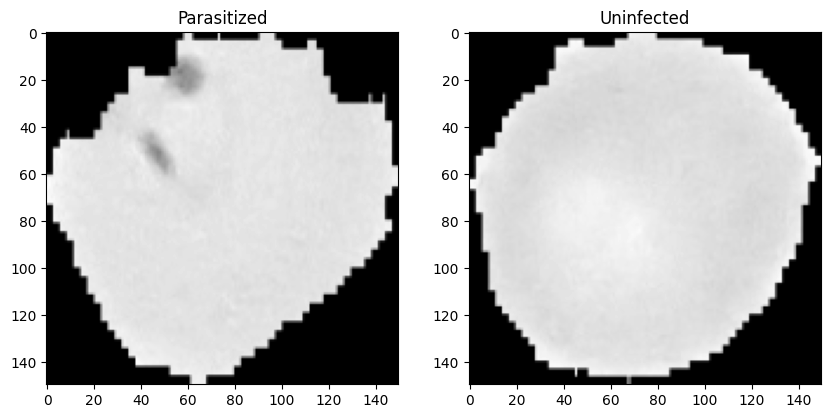

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(data[0][0], cmap='gray')
ax[0].set_title(labels[data[0][1]])

ax[1].imshow(data[-1][0], cmap='gray')
ax[1].set_title(labels[data[-1][1]])

plt.show()

In [ ]:
np.random.shuffle(data)

In [ ]:
from sklearn.model_selection import train_test_split

X = []
y = []

for i, label in data:
    X.append(i)
    y.append(label)

X_train_full, x_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, x_val, y_train, y_val = train_test_split(X_train_full, y_train_full, random_state=42)

In [ ]:
X_train = np.array(X_train) /255.0
x_val = np.array(x_val) /255.0
x_test = np.array(x_test) /255.0
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test= np.array(y_test)

In [ ]:
X_train.shape

(2214, 150, 150)

In [ ]:
X_train = X_train.reshape(-1, 224, 224, 3)

In [ ]:
#Pre-trained model testing VGG16, ResNet50 etc........
from tensorflow.keras.applications import ResNet50, InceptionResNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

from tensorflow.keras.applications import VGG16, VGG19
import tensorflow as tf
import tensorflow.keras.layers as L

num_classes = len(np.unique(labels))


# Load the pre-trained VGG16 model without the top classification layer
vgg16_base = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freeze the layers of the pre-trained model
for layer in vgg16_base.layers:
    layer.trainable = True

# Build the model using the Sequential
model = tf.keras.Sequential([
    vgg16_base,
    L.Dense(128, activation='relu'),
    L.BatchNormalization(renorm=True),
    L.Dropout(0.23),

    L.Dense(64, activation='relu'),
    L.BatchNormalization(renorm=True),
    L.Dropout(0.23),

    L.Dense(32, activation='relu'),
    L.BatchNormalization(renorm=True),
    L.Dropout(0.23),
    L.Dense(num_classes, activation='softmax')
], name='vgg16_transfer_learning')

#model summary
model.summary()

Model: "vgg16_transfer_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 batch_normalization (Batch  (None, 128)               896       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                448       
 chNormalization)                          

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation="relu", input_shape=(150, 150, 1)))  # Note the change here
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 3), activation="relu"))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "vgg16_transfer_learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 dense (Dense)               (None, 32)                40992     
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 66        
                                                                 
Total params: 2299042 (8.77 MB)
Trainable params: 2264930 (8.64 MB)
Non-trainable params: 34112 (133.25 KB)
_________________________________________________________________


In [ ]:
#Model 2 (Extra)
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    Dense,
    Dropout,
    Flatten,
    BatchNormalization
)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2

def Cmodel(input_shape, num_classes, kernel_regularizer=None):
    inputs = Input(shape=input_shape)

    # Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(inputs)
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(x)
    x = MaxPooling2D((2, 2), strides=(2,2))(x)

    # Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(x)
    x = MaxPooling2D((2, 2), strides=(2,2))(x)

    # Block 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=kernel_regularizer)(x)
    x = MaxPooling2D((2, 2), strides=(2,2))(x)

    # Flatten the output of the convolutional layers
    x = Flatten()(x)

    # Fully connected layers
    x = Dense(256, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    x = Dropout(0.25)(x)
    x = Dense(128, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    x = Dropout(0.25)(x)
    x = Dense(64, activation='relu', kernel_regularizer=kernel_regularizer)(x)
    x = Dropout(0.25)(x)

    # Output layer with softmax activation
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create the CD model
input_shape = (224, 224, 3)  # Adjust input shape as needed
num_classes = 2  # Adjust the number of classes
kernel_regularizer = l2(0.0001)  # l2 regularization
model = Cmodel(input_shape, num_classes, kernel_regularizer=kernel_regularizer)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 16)        0

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

from tensorflow.keras import models
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np

from tensorflow.keras.applications import MobileNetV2
import tensorflow as tf
import tensorflow.keras.layers as L

num_classes = 2


# Load the pre-trained MobileNetV2 model without the top classification layer
vgg16_base = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

# Freeze the layers of the pre-trained model
for layer in vgg16_base.layers:
    layer.trainable = True

# Build the model using the Sequential
model = tf.keras.Sequential([
    vgg16_base,
    L.Dense(32, activation='relu'),
    L.Dropout(0.2),
    L.Dense(num_classes, activation='softmax')
], name='vgg16_transfer_learning')

#model summary
model.summary()

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

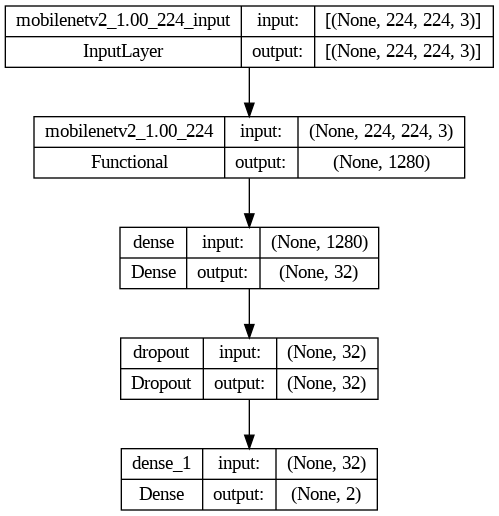

In [ ]:
keras.utils.plot_model(model, "Model_malaria.png", show_shapes=True)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)
epochs = 50

history = model.fit(X_train, y_train, epochs=epochs, callbacks=[early_stopping_cb], validation_data=(x_val, y_val))

Epoch 1/50


ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "vgg16_transfer_learning" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 150, 150)


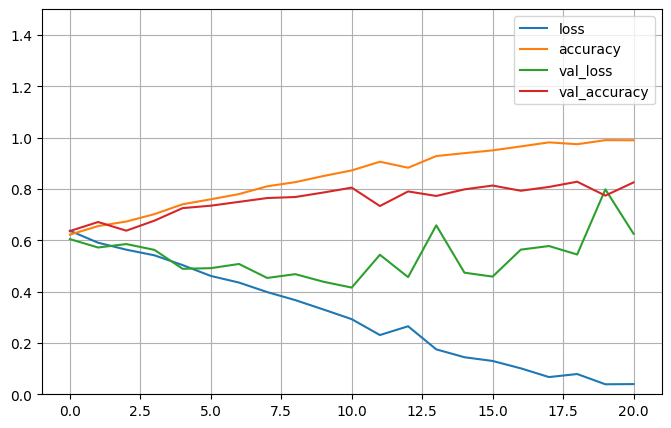

In [ ]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1.5)
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

24/24 [==============================] - 5s 190ms/step - loss: 0.4490 - accuracy: 0.7930


[0.44902899861335754, 0.792963445186615]

In [ ]:
y_test_pred = model.predict(x_test)
y_test_pred_labels = y_test_pred > 0.5
y_test_true_labels = y_test

24/24 [==============================] - 3s 126ms/step


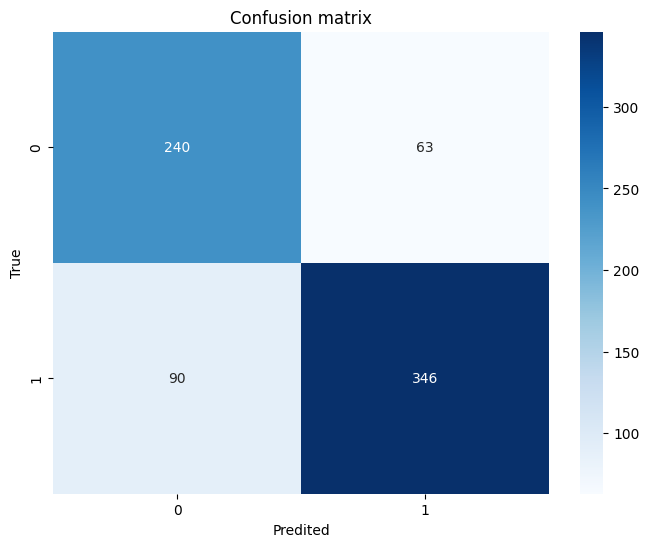

In [ ]:
cm = confusion_matrix(y_test_true_labels, y_test_pred_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('True')
plt.xlabel('Predited')
plt.title('Confusion matrix')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test_true_labels, y_test_pred_labels, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.7273    0.7921    0.7583       303
           1     0.8460    0.7936    0.8189       436

    accuracy                         0.7930       739
   macro avg     0.7866    0.7928    0.7886       739
weighted avg     0.7973    0.7930    0.7941       739



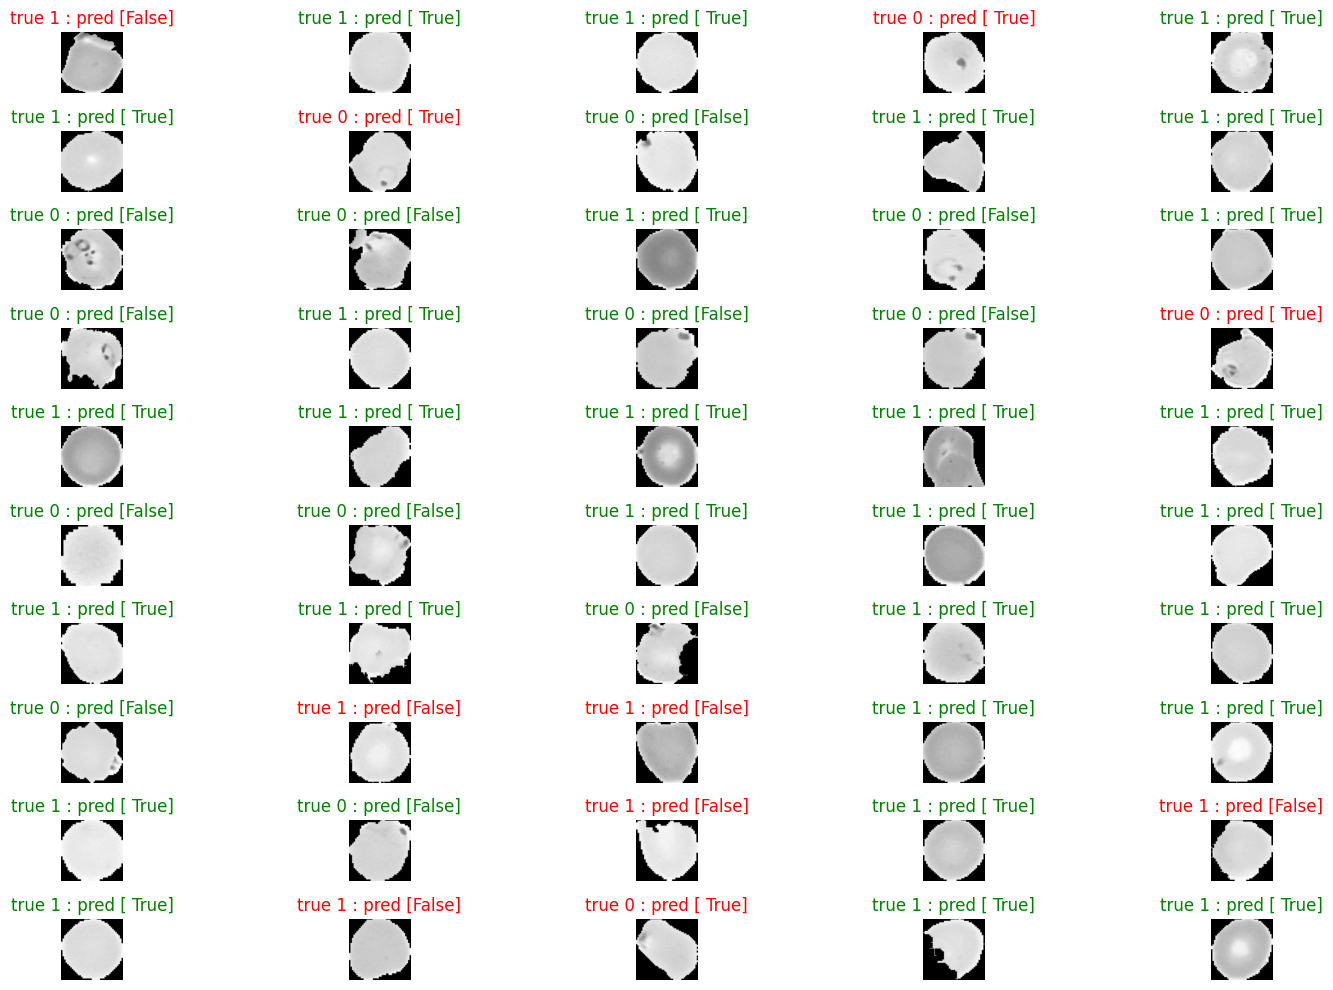

In [ ]:
fig, axs = plt.subplots(10, 5, figsize=(16, 10))
axs = axs.flatten()

for ax in axs:
    r = np.random.randint(0, x_test.shape[0])
    true_label = y_test_true_labels[r]
    pred_label = y_test_pred_labels[r]
    title_color = 'green' if true_label == pred_label else 'red'
    ax.imshow(x_test[r], cmap="gray")
    ax.set_title('true {} : pred {}'.format(true_label, pred_label), color=title_color)
    ax.axis('off')

plt.tight_layout()
plt.show()